<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial

In this notebook, we illustrate how to simulate seabird foraging trajectories using Deep Convolutional Generative Adversarial Networks [(DCGAN)](https://arxiv.org/pdf/1511.06434.pdf%C3)

## 1. Data exploration

### (a) import dataset

In [1]:
import pandas as pd

# import csv file from my github repository
url = 'https://raw.githubusercontent.com/AmedeeRoy/BirdGAN/master/data/trips_SV_200_steps.csv'
data = pd.read_csv(url)
data.head()

,trip,lon,lat,dive,datetime
0,P1108_12_SV_T1,-77.268339,-11.777933,0.184634,2008-11-29 19:51:00
1,P1108_12_SV_T1,-77.272344,-11.781284,0.031351,2008-11-29 19:52:00
2,P1108_12_SV_T1,-77.274705,-11.785334,0.010592,2008-11-29 19:53:00
3,P1108_12_SV_T1,-77.276275,-11.790922,0.108032,2008-11-29 19:54:00
4,P1108_12_SV_T1,-77.277807,-11.794704,0.616333,2008-11-29 19:55:00


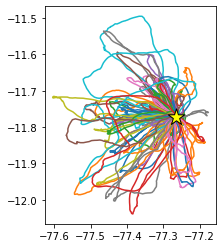

In [2]:
import matplotlib.pyplot as plt

colony = (-77.264, -11.773)

# quick plot of the data
for t in data.trip.unique():
  plt.plot(data.lon[data.trip == t], data.lat[data.trip == t], zorder = 1)
plt.scatter(colony[0], colony[1], marker = '*', color = 'yellow', edgecolors = 'black', s = 300, zorder = 2)
plt.gca().set_aspect(1)

### (b) format data

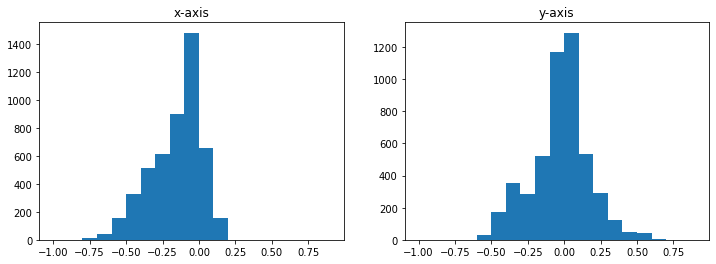

In [3]:
import numpy as np

# projection of coordinates in meters
R = 6377726 # earth radius
data['x'] = np.pi * R * (data['lon'] - colony[0])/180
data['y'] = np.pi * R * (data['lat'] - colony[1])/180

# standardization of (x,y) coordinates
scale = 5e4 # empirical choice
data['x_std'] = data['x']/scale
data['y_std'] = data['y']/scale

plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.hist(data.x_std, bins = np.arange(-1,1,0.1))
plt.title('x-axis')
plt.subplot(1,2,2)
plt.hist(data.y_std, bins = np.arange(-1,1,0.1))
plt.title('y-axis')
plt.show()

In [4]:
# padding all trajectories with zeros in a big matrix

padding = 200
traj_all = np.zeros((len(data.trip.unique()), 2, padding))

i = 0
for tt in data.trip.unique():
    traj = data[data.trip == tt].copy()
    traj = traj.loc[:,('x_std', 'y_std')].to_numpy()
    
    n = traj.shape[0]
    traj_all[i, :, 1:n+1] = traj.T
    i += 1

### (c) create dataloader

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset

In [6]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [7]:
# hyperparameters
batch_size = 32

## reduce size dataset
train_set = TrajDataSet(traj_all, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [8]:
x =  next(iter(train_loader))
x = x.cpu().numpy()

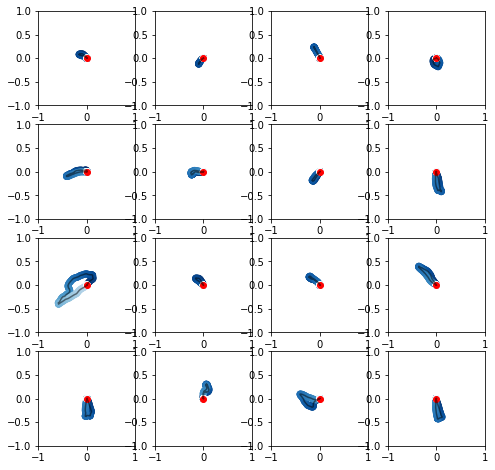

In [9]:
plt.figure(figsize = (8,8))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(x[i,0,:], x[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x[i,0,:], x[i,1,:], c=np.arange(padding), cmap='Blues_r')
    plt.scatter(0,0, c = 'red')
    plt.xlim(-1,1)
    plt.ylim(-1,1)

## 2. GAN Training

In [10]:
from torch import nn
from torch import optim
import progressbar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
    def forward(self, z):    
        out = self.cnn(z)
        return out


class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)



def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
# create network
generator = CNNGenerator().to(device)
discriminator = CNNDiscriminator().to(device)

# weight initialization
generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

# define loss and optimizers
criterion = nn.BCELoss()
lr = 0.0002
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))

  9% (499 of 5000) |##                   | Elapsed Time: 0:02:15 ETA:   0:18:36


Epoch [501/5000] -----------------------------------------------------------------------------


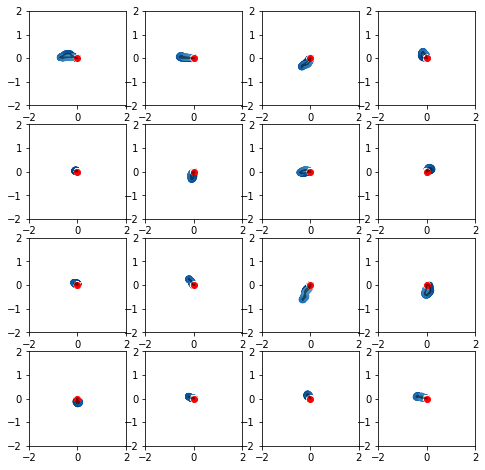

 19% (999 of 5000) |####                 | Elapsed Time: 0:04:36 ETA:   0:19:39


Epoch [1001/5000] -----------------------------------------------------------------------------


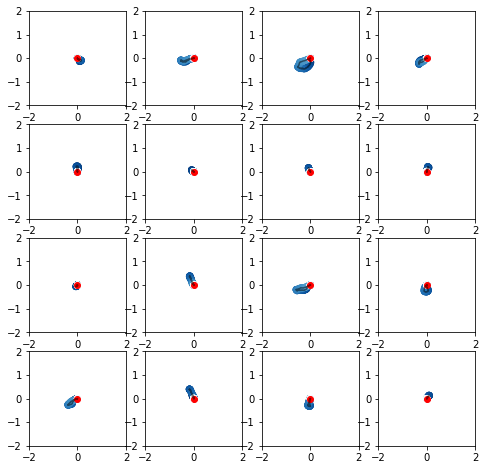

 29% (1499 of 5000) |#####               | Elapsed Time: 0:07:00 ETA:   0:16:58


Epoch [1501/5000] -----------------------------------------------------------------------------


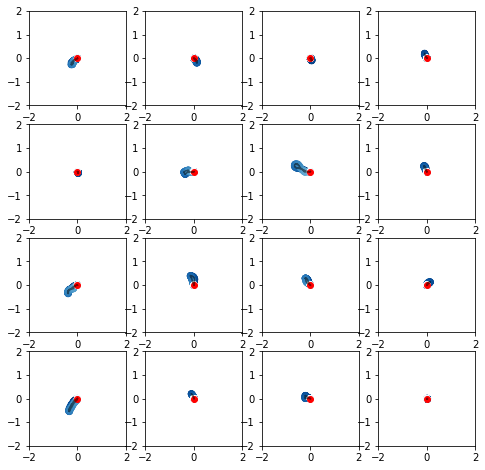

 39% (1999 of 5000) |#######             | Elapsed Time: 0:09:21 ETA:   0:14:48


Epoch [2001/5000] -----------------------------------------------------------------------------


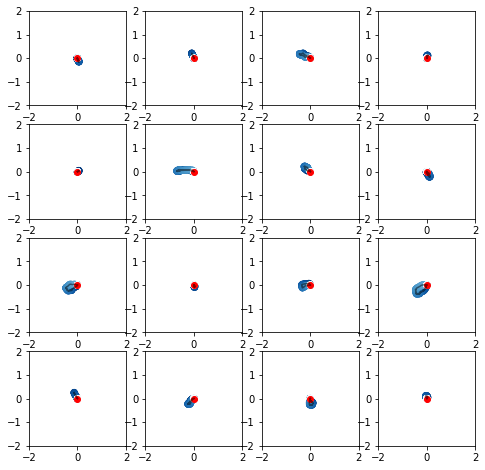

 49% (2499 of 5000) |#########           | Elapsed Time: 0:11:45 ETA:   0:11:44


Epoch [2501/5000] -----------------------------------------------------------------------------


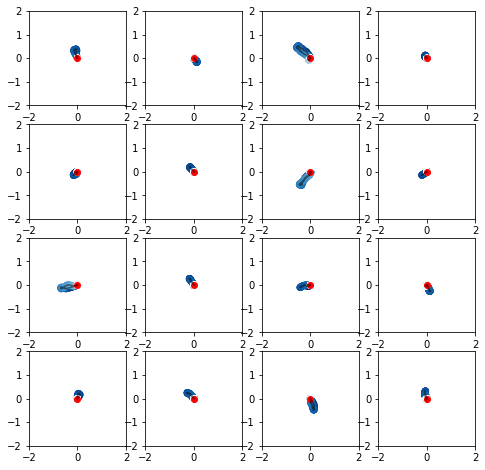

 59% (2999 of 5000) |###########         | Elapsed Time: 0:14:08 ETA:   0:09:41


Epoch [3001/5000] -----------------------------------------------------------------------------


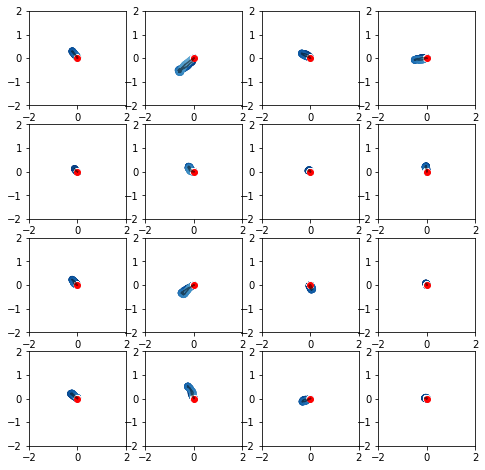

 69% (3499 of 5000) |#############       | Elapsed Time: 0:16:30 ETA:   0:06:54


Epoch [3501/5000] -----------------------------------------------------------------------------


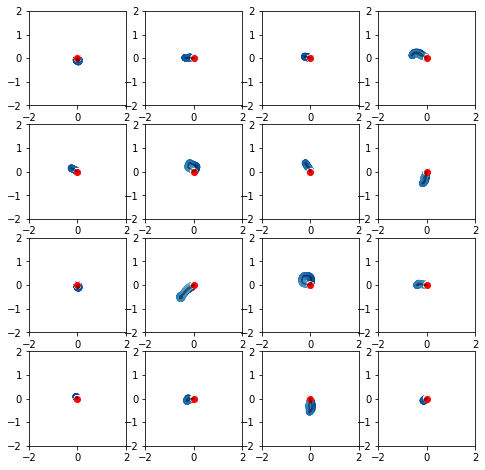

 79% (3999 of 5000) |###############     | Elapsed Time: 0:18:38 ETA:   0:04:02


Epoch [4001/5000] -----------------------------------------------------------------------------


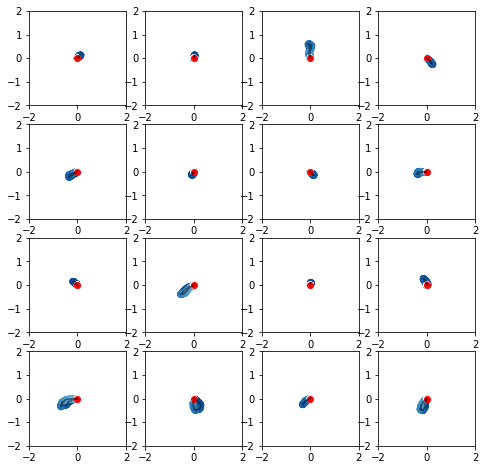

 89% (4499 of 5000) |#################   | Elapsed Time: 0:20:43 ETA:   0:02:03


Epoch [4501/5000] -----------------------------------------------------------------------------


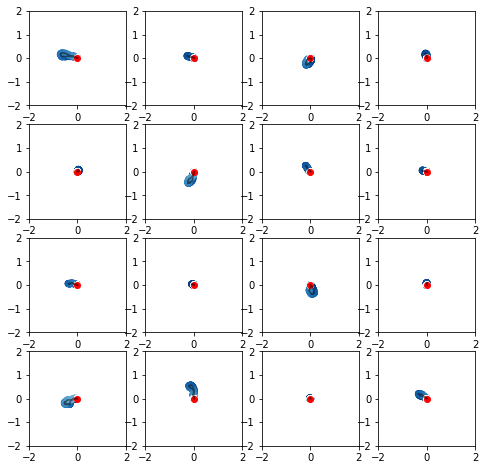

 99% (4999 of 5000) |################### | Elapsed Time: 0:22:49 ETA:   0:00:00


Epoch [5001/5000] -----------------------------------------------------------------------------


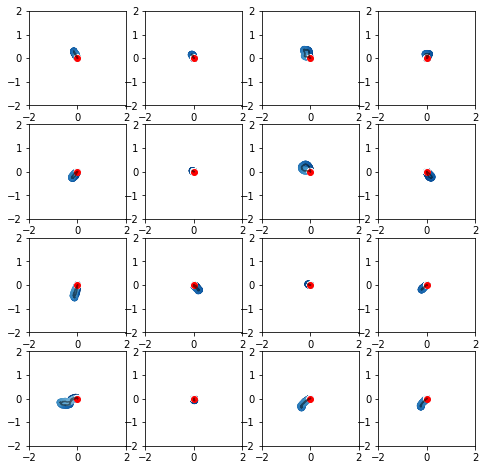

100% (5000 of 5000) |####################| Elapsed Time: 0:22:51 Time:  0:22:51


In [13]:
# Train the model
nb_epoch = 5000

epoch = 0
for i in progressbar.progressbar(range(nb_epoch)):
    epoch +=1
    for batch, x in enumerate(train_loader):
        
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)
        batch_size = x.shape[0]

        target_ones = torch.ones((batch_size, 1), device=device)
        target_zeros = torch.zeros((batch_size, 1), device=device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optim_d.step()

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)

        generated = generator(z)
        classifications = discriminator(generated)
        loss = criterion(classifications, target_ones)
        loss.backward()
        optim_g.step()

    if epoch%500 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch))
        
        nb = 16
        z = torch.randn((nb, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj_sim = generated.cpu().detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()


## 3. GAN performance evaluation

In [14]:
# generate synthetic trajectories
nb = 100
z = torch.randn((nb, 256, 1), device=device)
with torch.no_grad():
  generated = generator(z)

traj_sim = generated.cpu().detach().numpy()

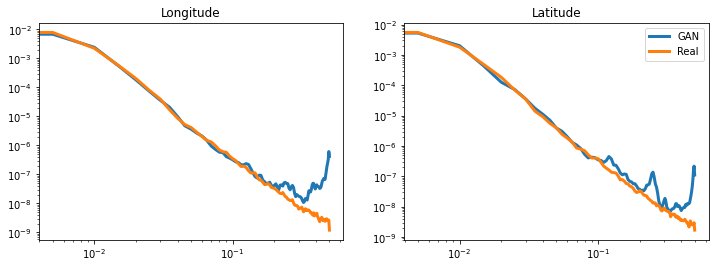

In [15]:
# Fourier spectral density
import scipy.signal as sp

def get_periodogram(traj):
    periodogram_lon = []
    periodogram_lat = []

    for j in range(traj.shape[0]):
        lon = traj[j, 0, :]
        lat = traj[j, 1, :]
        x, lon = sp.periodogram(lon, scaling = 'spectrum', detrend = False)
        x, lat = sp.periodogram(lat, scaling = 'spectrum', detrend = False)

        periodogram_lon.append(lon)
        periodogram_lat.append(lat)

    return (x, np.mean(periodogram_lon, axis=0), np.mean(periodogram_lat, axis=0))


(x, lon_all, lat_all) = get_periodogram(traj_all)
(x, lon_sim, lat_sim) = get_periodogram(traj_sim)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.loglog(x, lon_sim, linewidth = 3, label = 'GAN', color ='tab:blue')
plt.loglog(x, lon_all, linewidth = 3, label = 'Real', color='tab:orange')
plt.title('Longitude')
plt.subplot(1,2,2)
plt.loglog(x, lat_sim, linewidth = 3, label = 'GAN', color ='tab:blue')
plt.loglog(x, lat_all, linewidth = 3, label = 'Real', color='tab:orange')
plt.title('Latitude')
plt.legend()
plt.show()

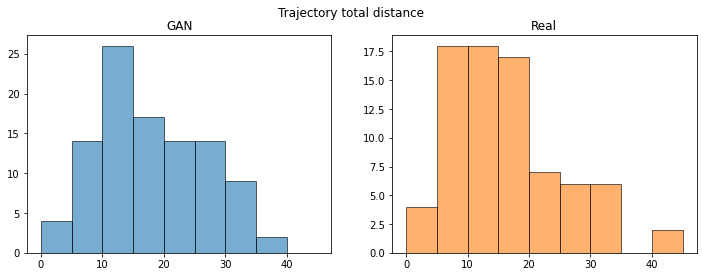

In [16]:
## Compare trajectories total distance

def coord2step(coord):
  step = np.sqrt(np.diff(coord[:,0,:])**2 + np.diff(coord[:,1,:])**2)
  step = np.append(np.zeros((coord.shape[0],1)), step, 1)
  direction = np.diff(np.arctan2(np.diff(coord[:,1,:]),np.diff(coord[:,0,:])))
  direction = np.append(np.zeros((coord.shape[0],2)), direction, 1)
  return np.stack([step*20, direction/2/np.pi], 1)

step_sim = coord2step(traj_sim)
step_all = coord2step(traj_all)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(np.sum(step_sim[:,0,:], 1), bins = np.arange(0, 50, 5), alpha = 0.6, color='tab:blue', edgecolor = 'black')
plt.title('GAN')
plt.subplot(1,2,2)
plt.hist(np.sum(step_all[:,0,:], 1), bins = np.arange(0, 50, 5), alpha = 0.6, color='tab:orange', edgecolor = 'black')
plt.title('Real')
plt.suptitle('Trajectory total distance')
plt.show()


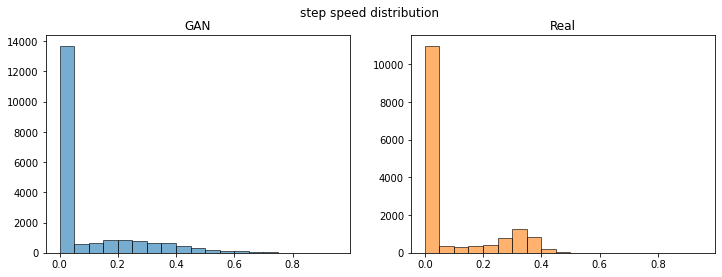

In [17]:
## Compare trajectories step distribution

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(step_sim[:,0,:].flatten(), bins = np.arange(0, 1, 0.05), alpha = 0.6, color='tab:blue', edgecolor = 'black')
plt.title('GAN')
plt.subplot(1,2,2)
plt.hist(step_all[:,0,:].flatten(), bins = np.arange(0, 1, 0.05), alpha = 0.6, color='tab:orange', edgecolor = 'black')
plt.title('Real')
plt.suptitle('step speed distribution')
plt.show()




---


DCGAN applied to seabird trajectories simulation are particularly relevant for capturing large-scale feature (e.g. trajectory total distance) however they fail to capture small-scale features (e.g. step speed distribution). This result is also illustrated by comparing Fourier density spectrum of Longitude and Latitude for real trajectories and synthetic ones.


---





# Ideas for improvement



### (a) Add layer to network for refining local scale

In [18]:
# class CNNGenerator(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.cnn = nn.Sequential(    
#             nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
#             nn.BatchNorm1d(128),
#             nn.ReLU(True),

#             nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(32),
#             nn.ReLU(True),

#             nn.ConvTranspose1d(32, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(16),
#             nn.ReLU(True),

#             nn.ConvTranspose1d(16, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(8),
#             nn.ReLU(True),

#             nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, bias = False),
#             nn.BatchNorm1d(8),
#             nn.ReLU(True),
#             nn.Conv1d(8, 2, kernel_size = 5, stride = 1, padding = 2, bias = False),
#             nn.Tanh()
#          )
#     def forward(self, z):    
#         out = self.cnn(z)
#         return out


# class CNNDiscriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
                
#         self.cnn = nn.Sequential(
#             nn.Conv1d(2, 8, kernel_size = 5, stride = 1, padding = 2, bias = False),
#             nn.BatchNorm1d(8),
#             nn.LeakyReLU(0.2, inplace=False),
#             nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, bias = False),
#             nn.BatchNorm1d(8),
#             nn.LeakyReLU(0.2, inplace=False),

#             nn.Conv1d(8, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(8),
#             nn.LeakyReLU(0.2, inplace=False),

#             nn.Conv1d(16, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(32),
#             nn.LeakyReLU(0.2, inplace=False),

#             nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(0.2, inplace=False),

#             nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
#             nn.Sigmoid()
#         )
#     def forward(self, x):
#         out = self.cnn(x)
#         return out.squeeze(1)

### (b) Add a spectral loss

In [19]:
# # function for spectral loss
# def periodogram(tt):
#   periodogram = torch.mean(torch.fft.fft(tt, 200).abs(), 0)
#   return torch.log(periodogram)

### (c) Add a step distribution density loss

In [20]:
# def differentiable_histogram(x, bins=255, min=0.0, max=1.0):

#     if len(x.shape) == 4:
#         n_samples, n_chns, _, _ = x.shape
#     elif len(x.shape) == 2:
#         n_samples, n_chns = 1, 1
#     else:
#         raise AssertionError('The dimension of input tensor should be 2 or 4.')

#     hist_torch = torch.zeros(n_samples, n_chns, bins).to(x.device)
#     delta = (max - min) / bins

#     BIN_Table = torch.arange(start=0, end=bins, step=1) * delta

#     for dim in range(1, bins-1, 1):
#         h_r = BIN_Table[dim].item()             # h_r
#         h_r_sub_1 = BIN_Table[dim - 1].item()   # h_(r-1)
#         h_r_plus_1 = BIN_Table[dim + 1].item()  # h_(r+1)

#         mask_sub = ((h_r > x) & (x >= h_r_sub_1)).float()
#         mask_plus = ((h_r_plus_1 > x) & (x >= h_r)).float()

#         hist_torch[:, :, dim] += torch.sum(((x - h_r_sub_1) * mask_sub).view(n_samples, n_chns, -1), dim=-1)
#         hist_torch[:, :, dim] += torch.sum(((h_r_plus_1 - x) * mask_plus).view(n_samples, n_chns, -1), dim=-1)

#     return hist_torch / delta